<a href="https://colab.research.google.com/github/khareyash05/Machine-Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
import PIL.Image as Image
import cv2

In [3]:
IMAGE_SHAPE = (224,224)
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5",input_shape = IMAGE_SHAPE + (3,))
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
Total params: 5,432,713
Trainable params: 0
Non-trainable params: 5,432,713
_________________________________________________________________


In [4]:
image = Image.open('/content/Flower Classification/Flower Classification/Validation Data/Daisy/Daisy (1).jpeg')

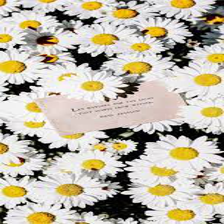

In [5]:
image = image.resize(IMAGE_SHAPE)
image

In [6]:
import numpy as np
image = np.array(image)/255.0
image.shape

(224, 224, 3)

In [7]:
image[np.newaxis,...].shape

(1, 224, 224, 3)

In [8]:
result = model.predict(image[np.newaxis,...])

1/1 [==============================] - 1s 832ms/step


In [9]:
predicted_label = np.argmax(result)
predicted_label

986

In [10]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [11]:
data_dir

'./datasets/flower_photos'

In [12]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [13]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/dandelion/4716316039_044e4d2d1a.jpg'),
 PosixPath('datasets/flower_photos/dandelion/14306875733_61d71c64c0_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/5749815755_12f9214649_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/19961979110_fcd8092388_m.jpg'),
 PosixPath('datasets/flower_photos/dandelion/17077940105_d2cd7b9ec4_n.jpg')]

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [15]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/3104672186_5f75647448_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2568105249_15720d081f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/4900231976_f8ced2b42a_n.jpg'),
 PosixPath('datasets/flower_photos/roses/7304710956_015b41f802_m.jpg'),
 PosixPath('datasets/flower_photos/roses/15277801151_5ed88f40f0_n.jpg')]

In [16]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [17]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [18]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [19]:
X = np.array(X)
y = np.array(y)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [22]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [23]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

In [24]:
predicted = model.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 576ms/step


array([612, 917, 612])

In [25]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [26]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0)

In [28]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
  metrics=['acc'])

history = model.fit(X_train_scaled, y_train, epochs=10 ,callbacks=[learning_rate_reduction])

Epoch 1/10
86/86 [==============================] - ETA: 0s - loss: 0.8534 - acc: 0.6788

86/86 [==============================] - 69s 754ms/step - loss: 0.8534 - acc: 0.6788 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - ETA: 0s - loss: 0.4227 - acc: 0.8594

86/86 [==============================] - 64s 750ms/step - loss: 0.4227 - acc: 0.8594 - lr: 0.0010
Epoch 3/10
86/86 [==============================] - ETA: 0s - loss: 0.3334 - acc: 0.8917

86/86 [==============================] - 64s 745ms/step - loss: 0.3334 - acc: 0.8917 - lr: 0.0010
Epoch 4/10
86/86 [==============================] - ETA: 0s - loss: 0.2779 - acc: 0.9117

86/86 [==============================] - 64s 743ms/step - loss: 0.2779 - acc: 0.9117 - lr: 0.0010
Epoch 5/10
86/86 [==============================] - ETA: 0s - loss: 0.2398 - acc: 0.9270

86/86 [==============================] - 73s 851ms/step - loss: 0.2398 - acc: 0.9270 - lr: 0.0010
Epoch 6/10
86/86 [==============================] - ETA: 0s - loss: 0.2112 - acc: 0.9382

86/86 [==============================] - 64s 748ms/step - loss: 0.2112 - acc: 0.9382 - lr: 0.0010
Epoch 7/10
86/86 [==============================] - ETA: 0s - loss: 0.1892 - acc: 0.9473

86/86 [==============================] - 64s 747ms/step - loss: 0.1892 - acc: 0.9473 - lr: 0.0010
Epoch 8/10
86/86 [==============================] - ETA: 0s - loss: 0.1679 - acc: 0.9604

86/86 [==============================] - 64s 747ms/step - loss: 0.1679 - acc: 0.9604 - lr: 0.0010
Epoch 9/10
86/86 [==============================] - ETA: 0s - loss: 0.1523 - acc: 0.9644

86/86 [==============================] - 67s 784ms/step - loss: 0.1523 - acc: 0.9644 - lr: 0.0010
Epoch 10/10
86/86 [==============================] - ETA: 0s - loss: 0.1368 - acc: 0.9698

86/86 [==============================] - 64s 749ms/step - loss: 0.1368 - acc: 0.9698 - lr: 0.0010


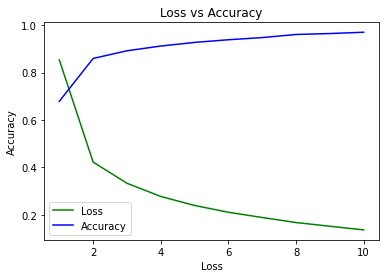

In [29]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['acc']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Loss')
plt.plot(epochs, loss_val, 'b', label='Accuracy')
plt.title('Loss vs Accuracy')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.legend()
plt.show()